In [53]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt


In [54]:
dataset_choice = input("Enter dataset (mnist / fashion): ").strip().lower()
epochs = int(input("Enter number of epochs (e.g., 30): "))
batch_size = int(input("Enter batch size (e.g., 128): "))
latent_dim = int(input("Enter latent dimension (e.g., 2 or 10): "))


Enter dataset (mnist / fashion): mnist
Enter number of epochs (e.g., 30): 30
Enter batch size (e.g., 128): 128
Enter latent dimension (e.g., 2 or 10): 2


In [55]:
if dataset_choice == "mnist":
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
elif dataset_choice == "fashion":
    (x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
else:
    raise ValueError("Invalid dataset")

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))


In [56]:
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


In [57]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])


In [58]:
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = layers.Reshape((28, 28, 1))(x)

decoder = models.Model(latent_inputs, outputs, name="decoder")


In [59]:
encoder = models.Model(inputs, [z_mean, z_log_var, z], name="encoder")
outputs = decoder(z)
vae = models.Model(inputs, outputs, name="vae")


In [60]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    # 🔹 THIS WAS MISSING
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction loss
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
        }


In [61]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")



In [63]:
history = vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size
)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 4.9556 - loss: 171.3246 - reconstruction_loss: 166.3690
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 5.0136 - loss: 167.3491 - reconstruction_loss: 162.3354
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - kl_loss: 5.0976 - loss: 164.9174 - reconstruction_loss: 159.8197
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - kl_loss: 5.1792 - loss: 163.0658 - reconstruction_loss: 157.8866
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 5.2948 - loss: 161.4692 - reconstruction_loss: 156.1744
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 5.3981 - loss: 160.1650 - reconstruction_loss: 154.7670
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - kl_loss: 5.4757 - loss: 159.0282 - reconstruction_loss: 153.5525
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 5.5289 - loss: 158.0723 - reconstruction_loss: 152.5434
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


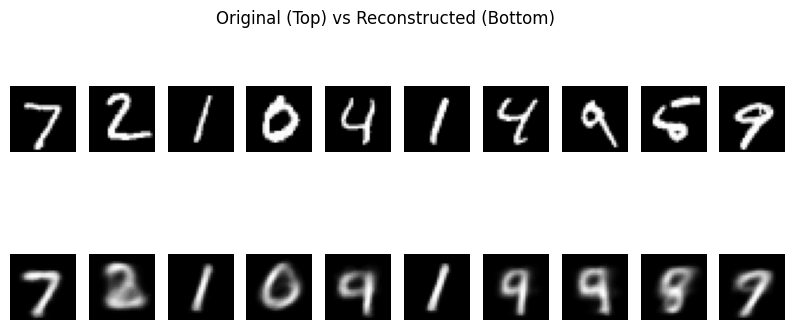

In [64]:
decoded_imgs = vae.predict(x_test[:10])

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


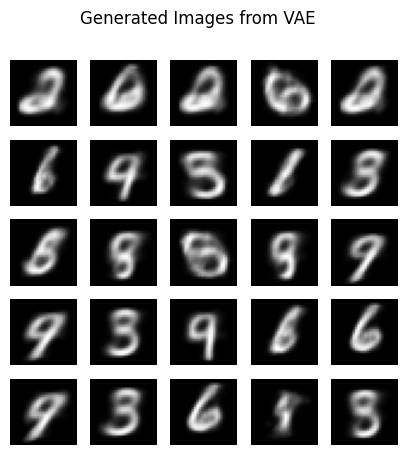

In [65]:
random_latent_vectors = np.random.normal(size=(25, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_images[i].reshape(28,28), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Images from VAE")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


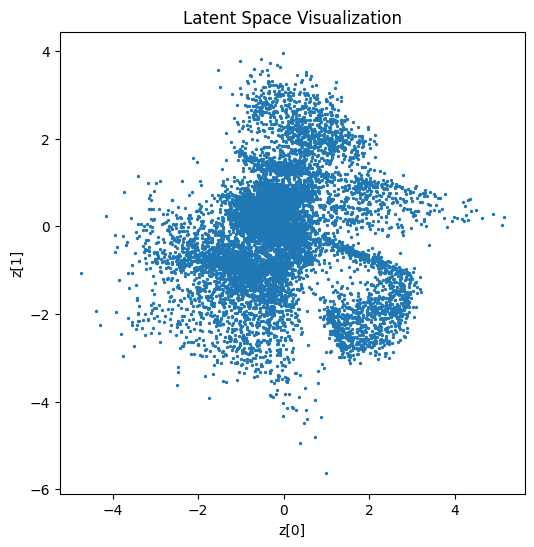

In [66]:
if latent_dim == 2:
    z_mean, _, _ = encoder.predict(x_test)
    plt.figure(figsize=(6,6))
    plt.scatter(z_mean[:,0], z_mean[:,1], s=2)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Visualization")
    plt.show()
